In [2]:
import requests as rq
import json
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import numpy as np
from textwrap import wrap
from matplotlib import pyplot as plt
from TCGA_files import *
#from ensembleAPI import geneinfo, genesinfo
from IPython.display import HTML
from sklearn import metrics
from hsbmpy import *

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 8 workers


In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import *

## query many

In [3]:
level = 1
#setup='highlyvariable_colonrectal'
#setup = 'oversigma_10tissue'
#label = 'disease_type'
label='primary_site'
L = 4
labels = ['primary_site', 'disease_type', 'disease_tissue']
#labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/results/tcga/oversampling_10tissue"
#directory = "/Users/filippo/Google Drive File Stream/My Drive/tesi_magistrale/tesi/results/hSBM/highlyvariable_7tissues"
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1
0,fffc1088-c5a6-46a0-b050-
1,543d90e4-9064-47c2-a68d-
2,538b497d-98a2-4e5b-afd6-
3,5327762f-5add-4008-ac5f-
4,52b5b223-897b-4b6a-b312-


In [29]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0])
#df_files.insert(2,'disease_tissue',["%s[%s]"%(df_files.at[s,'primary_site'],df_files.at[s,'disease_type']) for s in df_files.index])
labels=df_files.columns
#df_files.groupby(['primary_site','disease_type']).count()

In [ ]:
for normalise in [True, False]:
    for label in labels:
        for level in np.arange(L+1)[::-1]:
            if level==0:
                #pass
                continue
            print(normalise, label, level)
            try:
                cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
                fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)

                #fsdf = pd.DataFrame(data=fraction_sites)
                #fsdf = fsdf.drop('Other', axis=1)
                #fsdf = fsdf.divide(fsdf.sum(axis=1), axis=0).fillna(0)
                #fraction_sites = fsdf.sort_values(by=fsdf.columns.to_list(), ascending=True).to_dict(orient='list')

                clustersinfo = get_clustersinfo(cluster,fraction_sites)
                plot_cluster_composition(fraction_sites,directory,level,label=label, normalise=normalise,algorithm=algorithm)
                make_heatmap(fraction_sites, directory, label, level, normalise=normalise,algorithm=algorithm)

                clustersinfo = get_clustersinfo(cluster,fraction_sites)            
                if not normalise:
                    plot_maximum(clustersinfo,cluster,label,level, directory,algorithm=algorithm)
                    plot_maximum_size(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_maximum_label(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_sizes(level,directory, algorithm=algorithm)
            except:
                print(sys.exc_info()[0])
            try:
                fraction_sites_shuffle = get_fraction_sites(cluster, pd.read_csv("%s/files.dat.shuf"%directory, index_col=[0]),label=label, normalise=normalise)
                clustersinfo_shuffle = get_clustersinfo(cluster, fraction_sites_shuffle)
                plot_cluster_composition(fraction_sites_shuffle,directory,level, label=label, shuffled=True, normalise=normalise)
                if not normalise:
                    plot_maximum(clustersinfo,cluster,label,level,directory,clustersinfo_shuffle,algorithm=algorithm)
                    plot_maximum_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                    plot_maximum_label(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                    plot_labels_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
            except:
                print("must shuffle files")

In [7]:
##useful for R clustree plot
def reindex(x):
    i=1
    last=x[0]
    new = []
    for xi in x:
        if xi == last:
            pass
        else:
            i+=1
            last=xi
        new.append(i)
    return new

df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_labels = pd.DataFrame()
shape = df_clusters.dropna().shape
files = df_clusters.dropna().values.reshape(shape[0]*shape[1],)
for level in np.arange(L+1)[::-1]:
    print(level)
    df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,level), header=[0])
    currentlevellabels = []
    for file in files:
        s = df_clusters[df_clusters.isin([file])].any(0)
        a = s.index[s]
        currentlevellabels.append(int(a[0][8:])-1)
    df_labels.insert(0,'l%d'%level,currentlevellabels)
    del currentlevellabels
filelabels = []
filesublabels = []
for file in files:
    filelabels.append(get_file(file, df_files)[labels[0]])
    filesublabels.append(get_file(file, df_files)[labels[1]])
df_labels.insert(0,'tissue', filelabels)
df_labels.insert(0,'subtissue', filesublabels)
df_labels.sort_values(by=['tissue','subtissue'], inplace=True)
df_labels.sort_values(by=["l%d"%l for l in np.arange(L+1)[::-1]], axis=0, inplace=True)
filelabels = df_labels['tissue']
filesublabels = df_labels['subtissue']
df_labels = df_labels.apply(reindex, axis=0)
df_labels['tissue']=filelabels
df_labels['subtissue']=filesublabels
df_labels.to_csv("%s/%s/topsbm_labels.csv"%(directory,algorithm), index=False, header=True)

4
3
2
1
0


In [4]:
try:
    xl = getclustersizesarray(directory, L)
    with open("%s/clustersizes.txt" % directory, 'w') as f:
        for x in xl:
            f.write("%d\n" % x)
except:
    print("cannot save clustersizes.txt")

try:
    tl = gettopicsizesarray(directory, L)
    with open("%s/topicsizes.txt" % directory, 'w') as f:
        for x in tl:
            f.write("%d\n" % x)
except:
    print("cannot save topicsizes.txt")

In [22]:
scores = get_scores(directory, labels, l=L, verbose=False)

In [ ]:
try:
    xl = [len(get_cluster_given_l(li,directory)) for li in np.linspace(0,L,L+1)]
except:
    xl = [2,10,100,500]
with open("%s/clustersizes.txt"%directory,'w') as f:
    for x in xl:
        f.write("%d\n"%x)

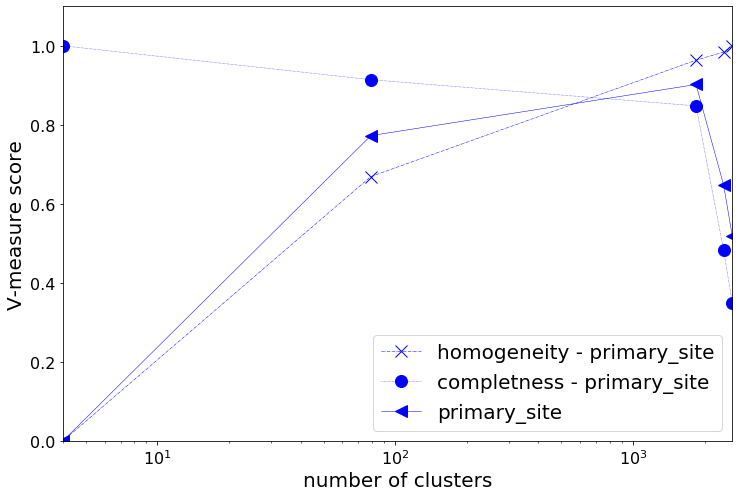

In [23]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,[labels[0]],xl, h=True, c=True, alpha=1)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

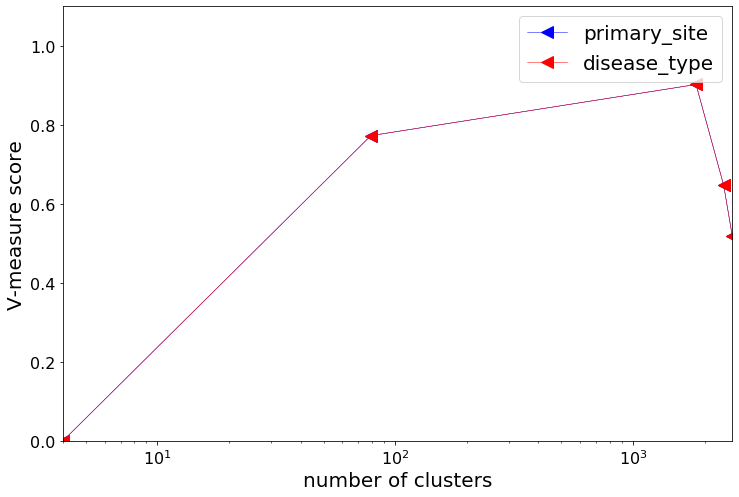

In [24]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels,xl)
#h = np.array(scores['primary_site']['h'])
#c = np.array(scores['secondary_site']['c'])
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("%s/metric_scores.pdf"%(directory))

In [ ]:
h = np.array(scores[labels[0]]['h'])
c = np.array(scores[labels[1]]['c'])
scores['hSBM'] = {
    'h':h,
    'c':c,
    'V':2*h*c/(h+c)
}

In [34]:
scores['hierarchical'] = pd.read_csv("%s/hierarchical.scores"%directory).to_dict(orient='list')
scores['lda'] = pd.read_csv("%s/lda.scores"%directory).to_dict(orient='list')
scores['hsbm->hierachical'] = pd.read_csv("%s/hierhsbm.scores"%directory).to_dict(orient='list')
scores['hsbm'] = scores['primary_site']

In [35]:
scores['lda'] = pd.read_csv("%s/lda.scores"%directory).to_dict(orient='list')

In [36]:
scores['hsbm'] = scores['primary_site']

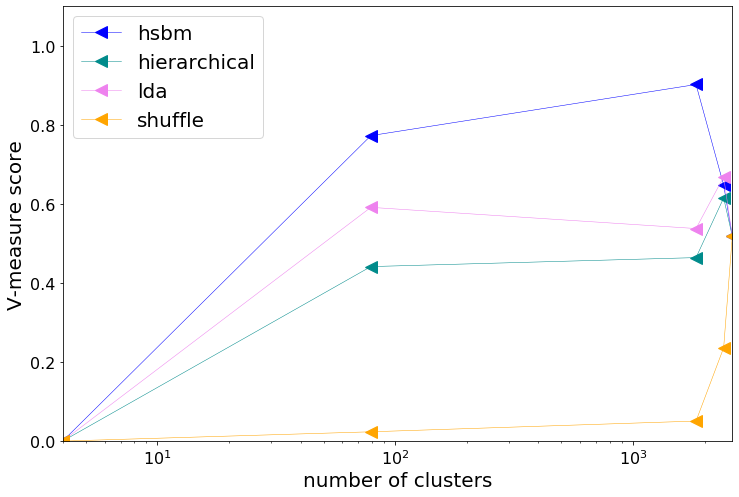

In [37]:
fig=plt.figure(figsize=(12,8))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels=['hsbm', 'lda', 'hierarchical', 'hsbm->hierachical', 'shuffle'],xl=xl)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("%s/metric_scores_all.pdf"%(directory))

In [38]:
X = pd.read_csv("%s/mainTable.csv"%directory, delimiter=',', index_col=0).transpose()

In [39]:
X = X.parallel_apply(lambda x: x/np.sum(x).astype(float), axis=1)

In [52]:
silhouettes = {}
algorithms = ['topsbm','lda', 'hierarchical', 'hierhsbm']
for algorithm in algorithms:
    print(algorithm)
    silhouettes[algorithm]=[]
    for level in np.arange(L+1)[::-1]:
        cluster = get_cluster_given_l(level, directory, algorithm=algorithm)
        predicted_labels = []
        for c in cluster:
            for sample in cluster[c]:
                try:
                    predicted_labels.append([get_file(sample,df_files).name,c])
                except:
                    print(sys.exc_info()[0])
                    print("error searching %s in %s" % (label,sample))
        predicted_labels=np.array(predicted_labels)
        labs = np.array([l[1] for l in predicted_labels if l[0] in X.index])
        X_values = X[X.index.isin([l for l in predicted_labels.T[0] if l in X.index])].values
        try:
            silhouettes[algorithm].append((metrics.silhouette_score(X_values, labs, metric='correlation')))
        except:
            print(sys.exc_info()[1])
            silhouettes[algorithm].append(np.nan)
silhouettes['hsbm']=silhouettes['topsbm']
silhouettes.pop('topsbm')

topsbm
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 793. Valid values are 2 to n_samples - 1 (inclusive)
lda
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 793. Valid values are 2 to n_samples - 1 (inclusive)
hierarchical
Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Number of labels is 793. Valid values are 2 to n_samples - 1 (inclusive)


[nan, 0.1574319884240598, 0.2818244501087534, -0.1582629636442797, nan]

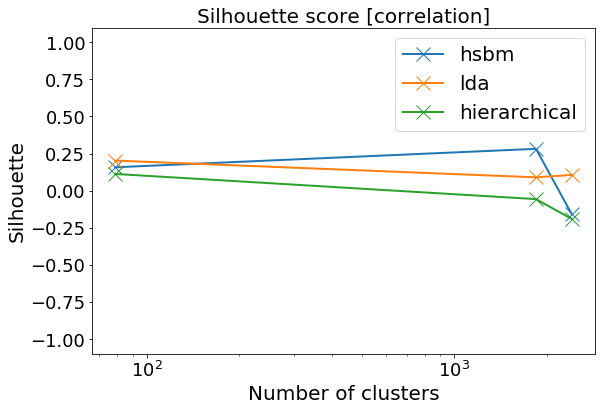

In [53]:
fig=plt.figure(figsize=(9,6))
for algorithm in ['hsbm', 'lda', 'hierarchical','hierhsbm']:
    plt.plot(xl[::-1],np.array(silhouettes[algorithm]), lw=2, ms=14, marker='x', label=algorithm)
plt.ylabel("Silhouette", fontsize=20)
plt.xlabel("Number of clusters", fontsize=20)
plt.title("Silhouette score [correlation]", fontsize=20)
plt.ylim((-1.1,1.1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xscale('log')
plt.legend(loc='best', fontsize=20)
plt.show()
fig.savefig("%s/silhouette.pdf"%directory)

In [ ]:
metrics.pairwise.PAIRWISE_DISTANCE_FUNCTIONS

# Benchmark
https://scikit-learn.org/stable/modules/clustering.html

In [ ]:
true_labels = []
predicted_labels = []
for c in cluster:
    print(c)
    for sample in cluster[c]:
        #true_labels.append(getFile(sample)['primary_site'].values[0])
        try:
            true_labels.append(df_files.loc[sample][label])
            predicted_labels.append(c)
        except:
            print("error in %s"%sample)

In [ ]:
_, labels_true = np.unique(true_labels,return_inverse=True)

In [ ]:
series_metrics=pd.Series(name=setup+'__level_%d_%s'%(level,label))
series_metrics['MI']=metrics.cluster.normalized_mutual_info_score(labels_true, predicted_labels, average_method='arithmetic')
series_metrics['Homogeneity']=metrics.cluster.homogeneity_score(labels_true, predicted_labels) 
series_metrics['Completness']=metrics.cluster.completeness_score(labels_true, predicted_labels) 
series_metrics['Vmeasure']=metrics.cluster.v_measure_score(labels_true, predicted_labels)
series_metrics['Fowlkes-Mallows']=metrics.cluster.fowlkes_mallows_score(labels_true,predicted_labels)
series_metrics['AdjustedRandIndex']=metrics.cluster.adjusted_rand_score(labels_true,predicted_labels)

In [ ]:
series_metrics

In [ ]:
#df_metrics = pd.DataFrame(columns=['AdjustedRandIndex','MI','Homogeneity','Completness','Vmeasure','Fowlkes-Mallows'])

In [ ]:
try:
    df_metrics.append(series_metrics, ignore_index=False, verify_integrity=True).to_csv("results/hSBM/metrics.csv", index=True,header=True)
except:
    raise

In [ ]:
df_metrics = pd.read_csv("results/hSBM/metrics.csv", index_col=[0],header=[0])
df_metrics.sort_values(by=['MI','Homogeneity'], ascending=False, axis=0, inplace=True)
df_metrics.round(decimals=2)

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(24, 20)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = pd.plotting.table(ax, df_metrics.round(decimals=2), loc='upper right', colWidths=[0.12]*len(df_metrics.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1, 2) # change size table
plt.savefig('results/hSBM/metrics.pdf', transparent=True)

In [ ]:
metrics.cluster.contingency_matrix(true_labels, predicted_labels)

In [ ]:
df_files[df_files['primary_site']=='Brain']